### Radius ~ r 

In [2]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def scatter_density_vs_radius_3D(rho_field, R0, grid_spacing, sample_fraction=1.0):
    """
    Plot rho_field as a scatter plot against radius r (3D only).

    Parameters
    ----------
    rho_field : np.ndarray
        The 3D density field (shape: [Nz, Ny, Nx]).
    R0 : tuple of floats
        The reference point (x0, y0, z0) in grid indices.
    grid_spacing : tuple of floats
        Physical size of one grid cell (dx, dy, dz).
    sample_fraction : float
        Fraction of points to randomly sample for plotting.
    """
    # Grid shape
    Nz, Ny, Nx = rho_field.shape
    # Create 3D grid of coordinates
    dz, dy, dx = grid_spacing
    z, y, x = np.indices((Nz, Ny, Nx))
    '''
    print(x[0, 0], y[0, 0], z[0, 0])  # Debugging: print first grid point
    [ 0  1  2 ... Nx], [0 0 0 0 ... 0], [0 0 0 0 ... 0]
    '''
    x_phys = x * dx
    y_phys = y * dy
    z_phys = z * dz
    # Compute radius relative to R0 (in physical units)
    x0, y0, z0 = R0
    x0 = 0.5 * x_phys.units
    y0 = 0.5 * y_phys.units
    z0 = 0.5 * z_phys.units
    r = np.sqrt(((x_phys - x0 )**2) + ((y_phys - y0 )**2) + ((z_phys - z0 )**2))
    # Flatten arrays
    r_flat = r.flatten()
    rho_flat = rho_field.flatten()
    # Optional: random sampling
    if sample_fraction < 1.0:
        N = len(r_flat)
        idx = np.random.choice(N, int(N * sample_fraction), replace=False)
        r_flat = r_flat[idx]
        rho_flat = rho_flat[idx]

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(r_flat, rho_flat, s=2, alpha=0.5, c=r_flat, cmap="viridis")
    plt.xlabel("Radius $r$ (relative to $R_0$)")
    plt.ylabel("Density $\\rho$")
    plt.title("3D Density Scatter Plot vs Radius")
    plt.colorbar(label="Radius $r$")
    plt.grid(True)
    plt.show()

### Function Units

When plotting the density as function of distance relative to center of mass, the fitting function is chosen as
$$\rho\left(r\right):=\rho_{\text{hi}} - \frac{\rho_{\text{hi}} - \rho_{\text{lo}}}{2}  \left[1 + \tanh\left(\frac{r - r_0}{W}\right)\right]$$
where $r_0$ denotes the droplet radius needed to fit. $\lim_{r\to 0}\rho=\rho_{\text{hi}}$, and $\lim_{r\to\infty}\rho=\rho_{\text{lo}}$.

$$\frac{d\rho}{dr}=-\frac{\rho_{\text{hi}}-\rho_{\text{lo}}}{2W}\frac{1}{\cosh^{2}\left(\frac{r-r_{0}}{W}\right)}$$

At $r=r_{0}$, slope is $-\frac{\rho_{\text{hi}}-\rho_{\text{lo}}}{2W}$, so the width is $\frac{\rho_{\text{hi}}-\rho_{\text{lo}}}{\frac{\rho_{\text{hi}}-\rho_{\text{lo}}}{2W}}=2W$. Given center of mass $\bm{r}_0$, we need to fit $\rho_{\text{hi}},\rho_{\text{lo}}$ and $W$.

In [3]:
def trapezoid_3d_weight(shape): 
    """
    Compute trapezoidal integration weights for a 3D grid.
    """
    nx, ny, nz = shape
    wt = np.ones(shape)
    # Apply trapezoidal weights along x-axis
    wt[0, :, :] *= 0.5
    wt[-1, :, :] *= 0.5
    # Apply trapezoidal weights along y-axis
    wt[:, 0, :] *= 0.5
    wt[:, -1, :] *= 0.5
    # Apply trapezoidal weights along z-axis
    wt[:, :, 0] *= 0.5
    wt[:, :, -1] *= 0.5
    return wt

def get_center_of_mass(rho_field, L, cell_centered=True):
    """
    Compute center of mass for a 3D density field using trapezoidal integration
    ----------
    rho_field : ndarray
        3D density field (shape: nx, ny, nz).
    L : tuple of float
        Physical dimensions of the domain (Lx, Ly, Lz).
    cell_centered : bool
        If True, grid is cell based; else node based.
    Returns
    -------
    vec_com : numpy.ndarray
        Center of mass [x_cm, y_cm, z_cm].
    """
    nx, ny, nz = rho_field.shape
    if cell_centered:
        dx, dy, dz = L[0] / nx, L[1] / ny, L[2] / nz
        x = (np.arange(nx) + 0.5) * dx
        y = (np.arange(ny) + 0.5) * dy
        z = (np.arange(nz) + 0.5) * dz
    else:  # node-centered
        dx, dy, dz = L[0] / (nx - 1), L[1] / (ny - 1), L[2] / (nz - 1)
        x = np.arange(nx) * dx
        y = np.arange(ny) * dy
        z = np.arange(nz) * dz

    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # Compute trapezoidal weights
    wt = trapezoid_3d_weight(rho_field.shape)

    # Total mass (weighted integral of density)
    mass = np.sum(rho_field * wt * dx * dy * dz)

    # Weighted coordinate integrals
    x_cm = np.sum(X * rho_field * wt * dx * dy * dz) / mass
    y_cm = np.sum(Y * rho_field * wt * dx * dy * dz) / mass
    z_cm = np.sum(Z * rho_field * wt * dx * dy * dz) / mass

    return np.array([x_cm, y_cm, z_cm])

def read_frame_density(file_path):
    ts = yt.load(file_path)
    profile_data = ts.covering_grid(
        level=0, left_edge=ts.domain_left_edge, dims=ts.domain_dimensions
    )
    profile = profile_data['boxlib', 'rho']
    # grid lattice length
    box  = ts.domain_dimensions
    L = ts.domain_right_edge - ts.domain_left_edge
    dr = L/box
    return profile, L, box, dr

def func_density_dist(rho_field, L, r0=None):
    """
    Flatten the 3D density field into a 1D array and compute the relative distance from the center.
    ----------
    rho_field : np.ndarray
        The 3D density field (shape: [Nz, Ny, Nx]).
    L : tuple of float
        Physical dimensions of the domain (Lx, Ly, Lz), used to convert from dimensionless to physical units.
    Returns
    -------
    np.ndarray
        Flattened 1D array of the density field & relative distance from the center.
    """
    if r0 is None:
        r0 = get_center_of_mass(rho_field, L)
    Nz, Ny, Nx = rho_field.shape
    # Create 3D grid of coordinates
    dx, dy, dz = L[0] / Nx, L[1] / Ny, L[2] / Nz
    x = (np.arange(Nx) + 0.5) * dx
    y = (np.arange(Ny) + 0.5) * dy
    z = (np.arange(Nz) + 0.5) * dz
    r0 *= dx.units  # Convert from dimensionless to physical units !
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    r = np.sqrt(((X - r0[0])**2) + ((Y - r0[1])**2) + ((Z - r0[2])**2))
    return rho_field.flatten(), r.flatten()

def fit_droplet_radius(rho_field, L, r0):
    """
    Fit droplet radius, width & max/min density by using a tanh function. See above.
    Returns: (rho_hi_fit, rho_lo_fit, radius_fit, W_fit) tuples
    """
    # Define the fitting function
    def tanh_profile(r, rho_hi, rho_lo, radius, W):
        return rho_hi - (rho_hi - rho_lo)/2 * (1 + np.tanh((r - radius)/W))

    rho_field_flatten, r = func_density_dist(rho_field, L, r0)
    # Fit the density profile to the tanh function
    popt, _ = curve_fit(tanh_profile, r, rho_field_flatten, p0=[rho_field_flatten.max(), rho_field_flatten.min(), 0.5, 0.5])
    rho_hi_fit, rho_lo_fit, radius_fit, W_fit = popt
    return rho_hi_fit, rho_lo_fit, radius_fit, W_fit

def density_PCA_matrix(rho_field, L, cell_centered=True):
    """
    Assemble the covariance matrix for the 3D density field --- principal component analysis (PCA) of the mass distribution
    """
    nx, ny, nz = rho_field.shape
    if cell_centered:
        dx, dy, dz = L[0] / nx, L[1] / ny, L[2] / nz
        x = (np.arange(nx) + 0.5) * dx
        y = (np.arange(ny) + 0.5) * dy
        z = (np.arange(nz) + 0.5) * dz
    else:  # node-centered
        dx, dy, dz = L[0] / (nx - 1), L[1] / (ny - 1), L[2] / (nz - 1)
        x = np.arange(nx) * dx
        y = np.arange(ny) * dy
        z = np.arange(nz) * dz

    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    r0 = get_center_of_mass(rho_field, L, cell_centered)*dx.units
    # Compute trapezoidal weights
    wt = trapezoid_3d_weight(rho_field.shape)

    # Total mass (weighted integral of density)
    mass = np.sum(rho_field * wt * dx * dy * dz)

    # Weighted coordinate integrals
    C_XX = np.sum((X-r0[0])*(X-r0[0]) * rho_field * wt * dx * dy * dz) / mass
    C_YY = np.sum((Y-r0[1])*(Y-r0[1]) * rho_field * wt * dx * dy * dz) / mass
    C_ZZ = np.sum((Z-r0[2])*(Z-r0[2]) * rho_field * wt * dx * dy * dz) / mass
    C_XY = np.sum((X-r0[0])*(Y-r0[1]) * rho_field * wt * dx * dy * dz) / mass
    C_YZ = np.sum((Y-r0[1])*(Z-r0[2]) * rho_field * wt * dx * dy * dz) / mass
    C_ZX = np.sum((Z-r0[2])*(X-r0[0]) * rho_field * wt * dx * dy * dz) / mass

    return np.array([[C_XX, C_XY, C_ZX],
              [C_XY, C_YY, C_YZ],
              [C_ZX, C_YZ, C_ZZ]])

def principal_axes(rho_field, L, radius, cell_centered=True):
    mat_C = density_PCA_matrix(rho_field, L, cell_centered)
    eigenvalues, eigenvectors = np.linalg.eig(mat_C)
    a = eigenvalues[0]**(1./3.)*radius/((eigenvalues[1]*eigenvalues[2])**(1./6.))
    b = eigenvalues[1]**(1./3.)*radius/((eigenvalues[0]*eigenvalues[2])**(1./6.))
    c = eigenvalues[2]**(1./3.)*radius/((eigenvalues[0]*eigenvalues[1])**(1./6.))
    return np.array([a, b, c]), eigenvalues, eigenvectors

### Plot single trajectory frame (droplet system): density $\rho\left(r\right)$ ~ relative distance to center-of-mass $r$

yt : [INFO     ] 2025-08-14 23:22:58,509 Parameters: current_time              = 820000.0
yt : [INFO     ] 2025-08-14 23:22:58,510 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:22:58,510 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-14 23:22:58,510 Parameters: domain_right_edge         = [1. 1. 1.]


Center of Mass: [0.51488052 0.51241728 0.5135624 ]
Fitted Droplet Radius: 0.23111855337459344
Eigenvalues: [0.01548751 0.01543184 0.01543958]
Eigenvectors:
 [[-0.5775583  -0.5875318  -0.56677402]
 [-0.68515398  0.7263378  -0.05474878]
 [-0.44383604 -0.35670686  0.82205218]]
Principal Axes (a, b, c): [0.23137677 0.2309606  0.23101851]
Residue Error for eigenvectors is (norm_p=2): 1.792141588980684e-17


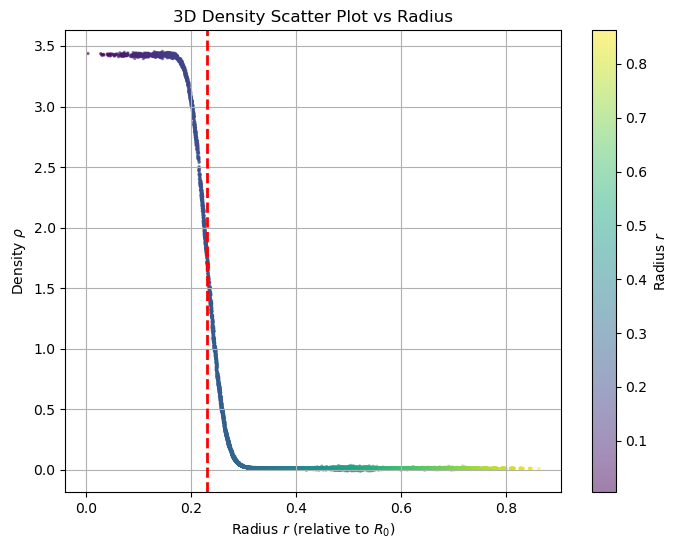

In [4]:
alpha0 = 1.5
temperature = 1e-5 #0.
frameIdx = 820000
r0 = 0.25
nx = 32
ny = 32
nz = 32
if temperature == 0.:
    file_path = "./data_droplet_alpha0_{:.2f}_r{:.2f}_size{:d}-{:d}-{:d}/lbm_data_shshan_alpha0_".format(alpha0, r0, nx, ny, nz) + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}/".format(nx, ny, nz) + "plt" + f"{frameIdx:07d}"
else:
    file_path = "./data_droplet_alpha0_{:.2f}_r{:.2f}_size{:d}-{:d}-{:d}/lbm_data_shshan_alpha0_".format(alpha0, r0, nx, ny, nz) + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}_continue/".format(nx, ny, nz) + "plt" + f"{frameIdx:07d}"

rho_field, L, box, dr = read_frame_density(file_path)
rho_flat, r_flat = func_density_dist(rho_field, L)
r0 = get_center_of_mass(rho_field, L)
print("Center of Mass:", r0)
rho_hi, rho_lo, R, W = fit_droplet_radius(rho_field, L, r0)
print("Fitted Droplet Radius:", R)
mat_C = density_PCA_matrix(rho_field, L)
pca_axes, eigenvalues, eigenvectors = principal_axes(rho_field, L, R)
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:\n", eigenvectors)
print("Principal Axes (a, b, c):", pca_axes)
residue_error = np.linalg.norm(mat_C @ eigenvectors[:, 0] - eigenvalues[0] * eigenvectors[:, 0], ord=2) + \
    np.linalg.norm(mat_C @ eigenvectors[:, 1] - eigenvalues[1] * eigenvectors[:, 1], ord=2) + \
    np.linalg.norm(mat_C @ eigenvectors[:, 2] - eigenvalues[2] * eigenvectors[:, 2], ord=2)
print("Residue Error for eigenvectors is (norm_p=2):", residue_error)

#print(rho_field.shape, box, dr)
#scatter_density_vs_radius_3D(rho_field, R0=(0.5, 0.5, 0.5), grid_spacing=(dr[0], dr[1], dr[2]))
plt.figure(figsize=(8, 6))
plt.scatter(r_flat, rho_flat, s=2, alpha=0.5, c=r_flat, cmap="viridis")
plt.axvline(x=R, color="red", linestyle="--", linewidth=2, label=f"$R={R}$")
plt.xlabel("Radius $r$ (relative to $R_0$)")
plt.ylabel("Density $\\rho$")
plt.title("3D Density Scatter Plot vs Radius")
plt.colorbar(label="Radius $r$")
plt.grid(True)
plt.show()

#### Density evolution -- Mass Conservation

Trajectories segments: box size $\left(32,32,32\right)$

##### $\text{temperature}=10^{-5}$
$$420000\ ~\ 820000,\ \text{plot\_int}=500$$
$$1220000\ ~\ 1620000,\ \text{plot\_int}=500$$
$$1820000\ ~\ 2020000,\ \text{plot\_int}=200$$

##### $\text{temperature}=10^{-4}$
$$1620000\ ~\ 1820000,\ \text{plot\_int}=200$$



yt : [INFO     ] 2025-08-14 23:22:59,180 Parameters: current_time              = 2620000.0
yt : [INFO     ] 2025-08-14 23:22:59,181 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:22:59,181 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-14 23:22:59,182 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-14 23:22:59,293 Parameters: current_time              = 2620200.0
yt : [INFO     ] 2025-08-14 23:22:59,294 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:22:59,295 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-14 23:22:59,296 Parameters: domain_right_edge         = [1. 1. 1.]


Processing frames from 2620000 to 3080000 with interval 200, total 2301 frames...


yt : [INFO     ] 2025-08-14 23:22:59,401 Parameters: current_time              = 2620400.0
yt : [INFO     ] 2025-08-14 23:22:59,401 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:22:59,402 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-14 23:22:59,403 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-14 23:22:59,508 Parameters: current_time              = 2620600.0
yt : [INFO     ] 2025-08-14 23:22:59,509 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:22:59,509 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-14 23:22:59,510 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-14 23:22:59,611 Parameters: current_time              = 2620800.0
yt : [INFO     ] 2025-08-14 23:22:59,611 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:22:59,612 Parameters: domain_left_edge          = [0

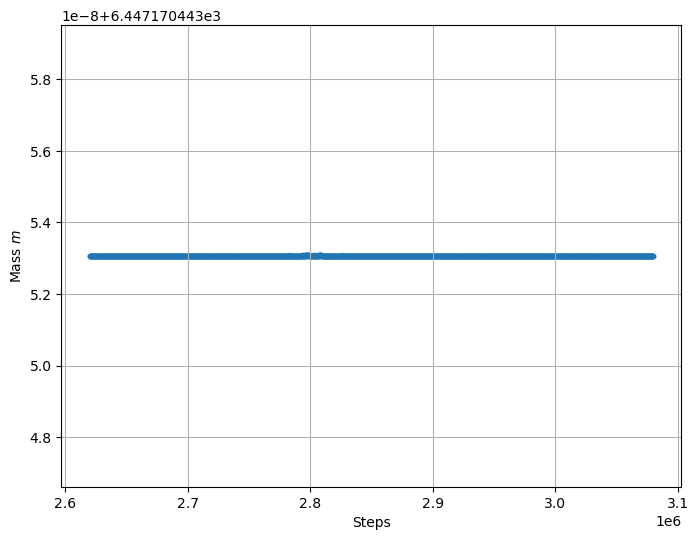

In [5]:
alpha0 = 1.5
temperature = 1e-5 #0.
frame1 = 2620000 #420000 #420000 #1220000
frame2 = 3080000 #820000 #820000 #1620000
plot_int = 200
N = (frame2 - frame1) // plot_int + 1
r_init = 0.25
nx = 32 #64
ny = 32 #64
nz = 32 #64

step_array = range(frame1, frame2+1, plot_int)
mass_array = np.zeros(N)
r0_array = np.zeros((N, 3))
r0_init = np.zeros(3)

print(f"Processing frames from {frame1} to {frame2} with interval {plot_int}, total {N} frames...")
# Loop through frames and compute instantaneous R(t) & principal axes a(t), b(t), c(t)
for n in range(N):
    frameIdx = frame1 + n*plot_int
    file_path = "./data_droplet_alpha0_{:.2f}_r{:.2f}_size{:d}-{:d}-{:d}/lbm_data_shshan_alpha0_".format(alpha0, r_init, nx, ny, nz) + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}_continue/".format(nx, ny, nz) + "plt" + f"{frameIdx:07d}"
    rho_field, L, box, dr = read_frame_density(file_path)
    vec_r0 = get_center_of_mass(rho_field, L)
    if n == 0:
        r0_init = vec_r0
    mass_array[n] = np.sum(rho_field)
    r0_array[n, :] = vec_r0 - r0_init

plt.figure(figsize=(8, 6))
plt.scatter(step_array, mass_array, s=10, alpha=0.5)
plt.xlabel("Steps")
plt.ylabel("Mass $m$")
plt.grid(True)
plt.show()

#### Plot center-of-mass trajectories

Processing frames from 2620000 to 3080000 with interval 200, total 2301 frames...


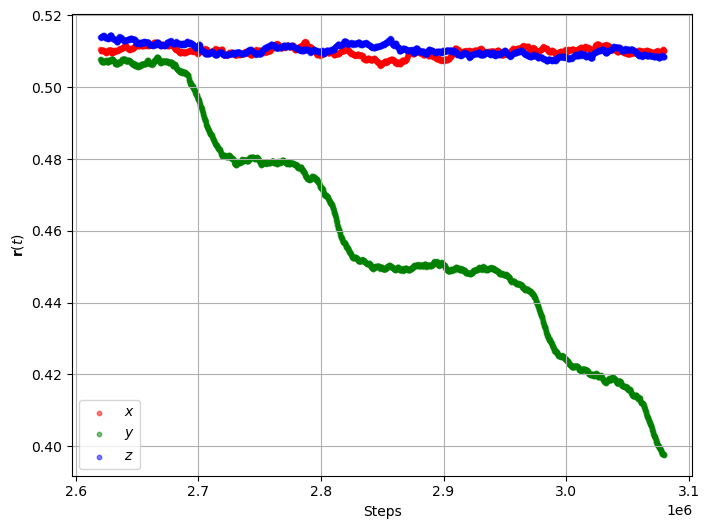

In [6]:
print(f"Processing frames from {frame1} to {frame2} with interval {plot_int}, total {N} frames...")

plt.figure(figsize=(8, 6))
plt.scatter(step_array, r0_array[:, 0] + r0_init[0], s=10, alpha=0.5, c='red', label=r'$x$')
plt.scatter(step_array, r0_array[:, 1] + r0_init[1], s=10, alpha=0.5, c='green', label=r'$y$')
plt.scatter(step_array, r0_array[:, 2] + r0_init[2], s=10, alpha=0.5, c='blue', label=r'$z$')
plt.xlabel("Steps")
plt.ylabel(r"$\mathbf{r}(t)$")
plt.legend()
plt.grid(True)
plt.show()

#### Plot center-of-mass displacement ~ steps

$$\left|\bm{r}\left(t\right)-\bm{r}_{0}\left(0\right)\right|\sim t$$

Processing frames from 2620000 to 3080000 with interval 200, total 2301 frames...


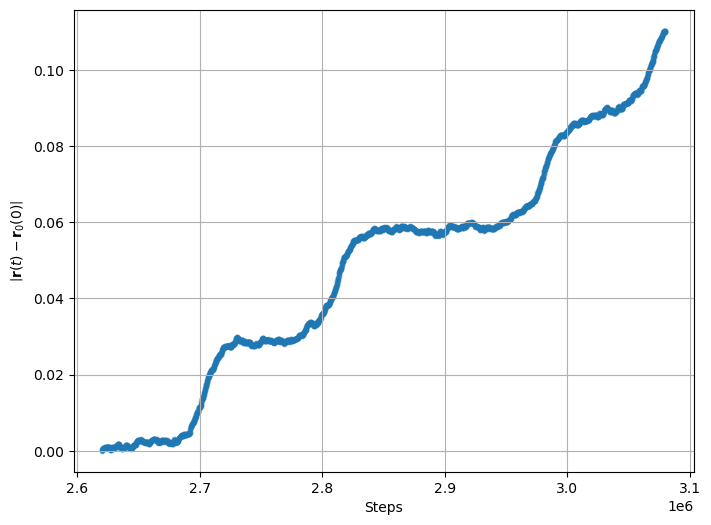

In [7]:
print(f"Processing frames from {frame1} to {frame2} with interval {plot_int}, total {N} frames...")

plt.figure(figsize=(8, 6))
plt.scatter(step_array, np.sqrt(np.sum(r0_array**2, axis=1)), s=10, alpha=0.5)
plt.xlabel("Steps")
plt.ylabel(r"$\left|\mathbf{r}(t) - \mathbf{r}_{0}(0)\right|$")
plt.grid(True)
plt.show()

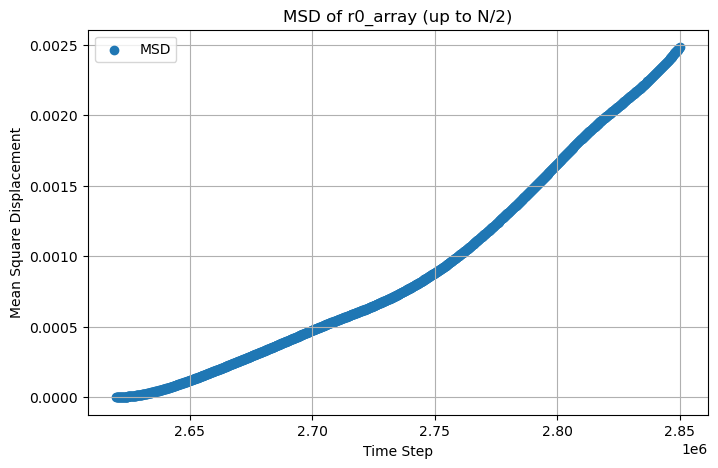

In [8]:
# Compute MSD
def compute_msd(r):
    N = r.shape[0]
    max_num_samples = N // 2
    num_samples = max_num_samples 
    msd = np.zeros(num_samples)
    for n in range(1, num_samples+1):
        diff = r[n:] - r[:-n]
        #print(diff.shape)
        msd[n-1] = np.mean(np.sum(diff[0:num_samples, :]**2, axis=1))
    return msd, num_samples

msd, num_samples = compute_msd(r0_array[0:6000])
# Insert MSD=0 at dt=0
msd = np.insert(msd, 0, 0.0)

plt.figure(figsize=(8, 5))
plt.scatter(range(frame1, frame1+num_samples*plot_int+1, plot_int), msd, label='MSD')
plt.xlabel('Time Step')
plt.ylabel('Mean Square Displacement')
plt.title('MSD of r0_array (up to N/2)')
plt.legend()
plt.grid(True)
plt.show()

### Loop through frames and compute instantaneous $R(t)$ & principal axes $a(t), b(t), c(t)$

In [9]:
#alpha0 = 1.5
#temperature = 1e-5 #0.
#plot_int = 500
#N = (frame2 - frame1) // plot_int + 1
#r_init = 0.25
#nx = 32
#ny = 32
#nz = 32

R_array = np.zeros(N)
a_array = np.zeros(N)
b_array = np.zeros(N)
c_array = np.zeros(N)

rho_frames_tensor = np.zeros((N, nx, ny, nz), dtype=np.float64)
if_save_density_each_frame = True

print(f"Processing frames from {frame1} to {frame2} with interval {plot_int}, total {N} frames...")
# Loop through frames and compute instantaneous R(t) & principal axes a(t), b(t), c(t)
for n in range(N):
    frameIdx = frame1 + n*plot_int
    file_path = "./data_droplet_alpha0_{:.2f}_r{:.2f}_size{:d}-{:d}-{:d}/lbm_data_shshan_alpha0_".format(alpha0, r_init, nx, ny, nz) + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}_continue/".format(nx, ny, nz) + "plt" + f"{frameIdx:07d}"
    
    rho_field, L, box, dr = read_frame_density(file_path)
    if if_save_density_each_frame:
      rho_frames_tensor[n, :, :, :] = rho_field # store the density field for later use
    r0 = get_center_of_mass(rho_field, L)
    rho_hi, rho_lo, R, W = fit_droplet_radius(rho_field, L, r0)
    pca_axes, eigenvalues, eigenvectors = principal_axes(rho_field, L, R)

    R_array[n] = R
    a_array[n] = pca_axes[0]
    b_array[n] = pca_axes[1]
    c_array[n] = pca_axes[2]

yt : [INFO     ] 2025-08-14 23:27:42,556 Parameters: current_time              = 2620000.0
yt : [INFO     ] 2025-08-14 23:27:42,557 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:27:42,558 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-14 23:27:42,558 Parameters: domain_right_edge         = [1. 1. 1.]


Processing frames from 2620000 to 3080000 with interval 200, total 2301 frames...


yt : [INFO     ] 2025-08-14 23:27:42,743 Parameters: current_time              = 2620200.0
yt : [INFO     ] 2025-08-14 23:27:42,744 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:27:42,745 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-14 23:27:42,746 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-14 23:27:43,090 Parameters: current_time              = 2620400.0
yt : [INFO     ] 2025-08-14 23:27:43,091 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:27:43,091 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-14 23:27:43,092 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-14 23:27:43,262 Parameters: current_time              = 2620600.0
yt : [INFO     ] 2025-08-14 23:27:43,262 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:27:43,263 Parameters: domain_left_edge          = [0

#### Ensemble average for $\sum_{i=1}^{2}\sum_{j=i+1}^{3}\left\langle \left[\delta a_{i}\left(t\right)+\delta a_{j}\left(t\right)\right]^{2}\right\rangle $ and $\sum_{i=1}^{2}\sum_{j=i+1}^{3}\left\langle \left[\delta a_{i}\left(t\right)-\delta a_{j}\left(t\right)\right]^{2}\right\rangle $

In [10]:
delta_a_array = a_array - R_array
delta_b_array = b_array - R_array
delta_c_array = c_array - R_array

t_window = 100000
N_win = (frame2-t_window-frame1)//plot_int
print("number of frames per observation window is:", N_win)
corvariance_plus = np.zeros(N_win)
corvariance_minus = np.zeros(N_win)

for n in range(frame1, frame2-t_window, plot_int):
    win_idx = (n-frame1)//plot_int
    corvariance_plus[win_idx] = np.mean((delta_a_array[win_idx:(win_idx + N_win)] + delta_b_array[win_idx:(win_idx + N_win)])**2 +\
                                (delta_a_array[win_idx:(win_idx + N_win)] + delta_c_array[win_idx:(win_idx + N_win)])**2 +\
                                      (delta_b_array[win_idx:(win_idx + N_win)] + delta_c_array[win_idx:(win_idx + N_win)])**2)
    corvariance_minus[win_idx] = np.mean((delta_a_array[win_idx:(win_idx + N_win)] - delta_b_array[win_idx:(win_idx + N_win)])**2 +\
                                 (delta_a_array[win_idx:(win_idx + N_win)] - delta_c_array[win_idx:(win_idx + N_win)])**2 +\
                                      (delta_b_array[win_idx:(win_idx + N_win)] - delta_c_array[win_idx:(win_idx + N_win)])**2)

    corvariance_plus[win_idx] = corvariance_plus[win_idx]/(dr[0]**2.)
    corvariance_minus[win_idx] = corvariance_minus[win_idx]/(dr[0]**2.)


number of frames per observation window is: 1800


#### Surface Tension
$$\gamma_{\left(2,0\right)}=\frac{15k_{B}T}{16\pi\sum_{i=1}^{2}\sum_{j=i+1}^{3}\left\langle \left[\delta a_{i}\left(t\right)+\delta a_{j}\left(t\right)\right]^{2}\right\rangle },\ \ \ \gamma_{\left(2,\pm2\right)}=\frac{45k_{B}T}{16\pi\sum_{i=1}^{2}\sum_{j=i+1}^{3}\left\langle \left[\delta a_{i}\left(t\right)-\delta a_{j}\left(t\right)\right]^{2}\right\rangle }$$

<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_2123/794622041.py:8: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$\gamma$")


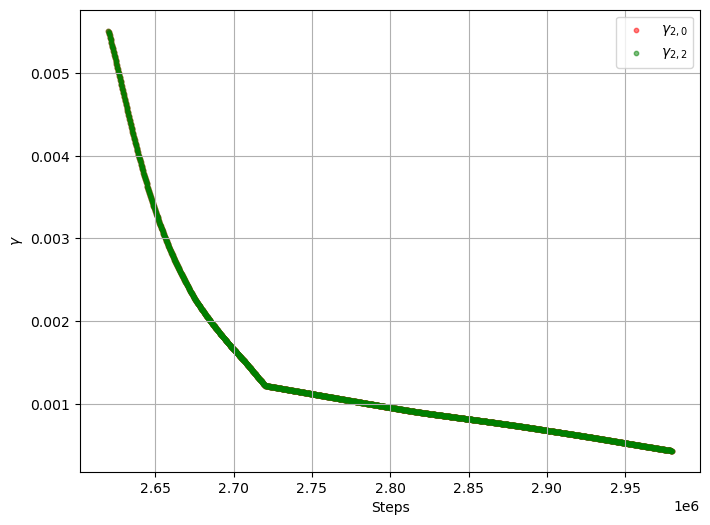

0.0001292339683921641 1/code_length
0.02651628579814125 1/code_length
0.013307638591990292 1/code_length
0.013097171127793118 1/code_length


In [11]:
gamma_2_0 = 15.*temperature/(16.*np.pi*corvariance_plus)
gamma_2_2 = 45.*temperature/(16.*np.pi*corvariance_minus)

plt.figure(figsize=(8, 6))
plt.scatter(range(frame1, frame2-t_window, plot_int), gamma_2_0, s=10, alpha=0.5, c='red', label=r'$\gamma_{2,0}$')
plt.scatter(range(frame1, frame2-t_window, plot_int), gamma_2_2, s=10, alpha=0.5, c='green', label=r'$\gamma_{2,2}$')
plt.xlabel("Steps")
plt.ylabel("$\gamma$")
plt.legend()
plt.grid(True)
plt.show()

print(np.mean(np.abs(delta_a_array + delta_b_array + delta_c_array))/dr[0])
print(np.mean(np.abs(delta_a_array))/dr[0])
print(np.mean(np.abs(delta_b_array))/dr[0])
print(np.mean(np.abs(delta_c_array))/dr[0])

size-32-32-32
frame1 = 1220000
frame2 = 1620000
2.471046124556462e-06 1/code_length
0.004532194654529034 1/code_length

frame1 = 420000
frame2 = 820000
3.842681673557852e-06 1/code_length
0.005783613525256861 1/code_length
0.002976382368320943 1/code_length
0.0028240120115155046 1/code_length

size-64-64-64
1.212882521169698e-06 1/code_length
0.004583951121207923 1/code_length
0.0023734380471268305 1/code_length
0.0022523934738637847 1/code_length

#### Marching Cubes
https://graphics.stanford.edu/~mdfisher/MarchingCubes.html

Overall, this is achieved by interpolating the position of vertices along the edges of the cube based on the isovalue

#### Hamiltonian for surface oscillations of droplet
$$r\left(\theta,\phi,t\right):=R\left(t\right)+\zeta\left(\theta,\phi,t\right),\ \ \ R\left(t\right)=\frac{1}{4\pi}\int r\left(\theta,\phi,t\right)\sin\theta d\theta d\phi$$

$$r\left(\theta,\phi,t\right)=R\left(t\right)+\sum_{l\ge\left|m\right|,m}\zeta_{lm}\left(t\right)Y_{l}^{\left(m\right)}\left(\theta,\phi\right),\ \ \ a_{0}\left(t\right)=R\left(t\right)$$

Total 4 radius concepts:
$$R\left(t\right),\ R\left(t,\theta,\phi\right),\ R_0,\ R_{\text{tanh\_fit}}\left(t\right)$$

#### variables descriptions
    rho_frames_tensor:    4D array of density field, [N, nx, ny, nz] (N is the number of frames)

    centers_of_mass:    2D array of center of mass coordinate, [N, 3] (in lb unit)


Select frames have average: max = 3.4528795444782343, min = -0.013160537498382708


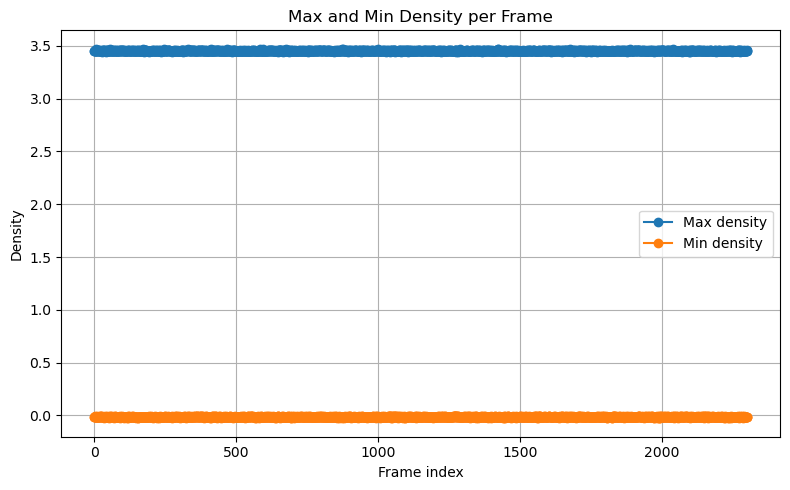

In [12]:
import numpy as np
from skimage import measure

# Compute max and min for each frame
max_vals = np.max(rho_frames_tensor, axis=(1, 2, 3))
min_vals = np.min(rho_frames_tensor, axis=(1, 2, 3))
rho_lo = min_vals.mean()
rho_hi = max_vals.mean()
print(f"Select frames have average: max = {rho_hi}, min = {rho_lo}")
# Plot
plt.figure(figsize=(8, 5))
plt.plot(max_vals, label='Max density', marker='o')
plt.plot(min_vals, label='Min density', marker='o')
plt.xlabel('Frame index')
plt.ylabel('Density')
plt.title('Max and Min Density per Frame')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

x = np.arange(nx)
y = np.arange(ny)
z = np.arange(nz)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')  # shape (nx, ny, nz)
centers_of_mass = np.zeros((N, 3))
for i in range(N):
    rho = rho_frames_tensor[i]  # shape (nx, ny, nz)
    total_mass = np.sum(rho)
    cx = np.sum(rho * X) / total_mass
    cy = np.sum(rho * Y) / total_mass
    cz = np.sum(rho * Z) / total_mass
    centers_of_mass[i] = (cx, cy, cz)

#### Harmonic expansion coefficients -- Conjugate Relation
$$Y_{l}^{m}\left(\theta,\phi\right)=\sqrt{\frac{2l+1}{4\pi}\frac{\left(l-m\right)!}{\left(l+m\right)!}}e^{im\phi}P_{l}^{m}\left(\cos\theta\right)$$

\begin{aligned}
Y_{l}^{m}\left(\theta,\phi\right)^{*}&=\sqrt{\frac{2l+1}{4\pi}\frac{\left(l-m\right)!}{\left(l+m\right)!}}e^{-im\phi}P_{l}^{m}\left(\cos\theta\right)\ \ \ \ \ \ m\ge0\\&=\sqrt{\frac{2l+1}{4\pi}\frac{\left(l-m\right)!}{\left(l+m\right)!}}e^{-im\phi}\left(-1\right)^{m}\frac{\left(l+m\right)!}{\left(l-m\right)!}P_{l}^{-m}\left(\cos\theta\right)\\&=\left(-1\right)^{m}\sqrt{\frac{2l+1}{4\pi}\frac{\left(l+m\right)!}{\left(l-m\right)!}}e^{-im\phi}P_{l}^{-m}\left(\cos\theta\right)\\&=\left(-1\right)^{m}Y_{l}^{-m}\left(\theta,\phi\right)
\end{aligned}

$$Y_{l}^{-m}\left(\theta,\phi\right)=\left(-1\right)^{m}Y_{l}^{m}\left(\theta,\phi\right)^{*}\ \ \to\ \ \left|Y_{l}^{-m}\left(\theta,\phi\right)\right|=\left|Y_{l}^{m}\left(\theta,\phi\right)^{*}\right|$$

$$N_{lm}=\left\Vert Y_{l}^{m}\left(\theta,\phi\right)\right\Vert =1\ \ -l\le m\le l$$

Besides norm of function $e^{im\phi}P_{l}^{\left|m\right|}\left(\cos\theta\right)$ is
$$\sqrt{\frac{4\pi}{2l+1}\frac{\left(l+\left|m\right|\right)!}{\left(l-\left|m\right|\right)!}}\ \ -l\le m\le l$$

So for odd $m=1,3,...$, $\zeta_{l,-m}=-\zeta_{lm}^*$; for even $m=2,4,...$, $\zeta_{l,-m}=\zeta_{lm}^*$. Thus

$$\zeta_{l,-m}Y_{l}^{-m}\left(\theta,\phi\right) = \zeta_{l,m}^*Y_{l}^{m}\left(\theta,\phi\right)^*$$

        def spherical_harmonics_coefficients: compute harmonic expansion coefficients for single frame [frame_select_idx] 
        in trajectories [rho_frames_tensor]; 
        L_max: maximum eigennumber


In [34]:
from scipy.special import sph_harm

frame_select_idx = 0
def spherical_harmonics_coefficients(rho_frames_tensor, centers_of_mass, print_info=True, frame_select_idx=0, L_max=5, test_info=True):
    rho_frame_select = rho_frames_tensor[frame_select_idx, :, :, :]  # Use the selected frame's density field for testing
    rho_lo = rho_frame_select.min()
    rho_hi = rho_frame_select.max()
    rho_interface_level = 0.5 * (rho_lo + rho_hi)  # example
    verts, faces, normals, values = measure.marching_cubes(rho_frame_select, level=rho_interface_level)
    # Shift verts to center
    shifted_verts = verts - centers_of_mass[frame_select_idx]  # shape (num_of_verts,3)
    # Cartesian to spherical
    x, y, z = shifted_verts[:,0], shifted_verts[:,1], shifted_verts[:,2]    # shape (num_of_verts,)
    # print(x.shape, y.shape, z.shape)
    # Compute spherical coordinates of all droplet surface vertices
    r = np.linalg.norm(shifted_verts, axis=1)
    theta = np.arccos(z / (r + 1e-15))    # polar angle [0, pi]
    phi = np.arctan2(y, x)                # azimuthal angle [-pi, pi]
    if print_info:
        print(f"Select frame {frame_select_idx} has density field: Max = {rho_frame_select.max()}, Min = {rho_frame_select.min()}")
        print("Total vertices number:", verts.shape[0])
        print("Total faces number:", faces.shape[0])
        print("Spherical coordinates: r, theta, phi shapes:", r.shape, theta.shape, phi.shape)

    # --- Step 1: Compute barycentric vertex area weights
    v0 = shifted_verts[faces[:,0]] # of size (num_of_faces, 3), in which faces[:,0] is the index of the first vertex of each triangle
    v1 = shifted_verts[faces[:,1]]
    v2 = shifted_verts[faces[:,2]]
    cross = np.cross(v1 - v0, v2 - v0) # surface area for each triangle
    unit_n_vector = cross / (np.linalg.norm(cross, axis=1, keepdims=True) + 1e-15)  # Normalize to get unit normal vectors
    triangle_area = 0.5 * np.linalg.norm(cross, axis=1)  # Triangle areas, of size (num_of_faces, 1)
    # print(triangle_area.shape)

    centroid = (v0 + v1 + v2) / 3.0                      # of size (num_of_faces, 3)
    r0 = np.linalg.norm(centroid, axis=1)                 # of size (num_of_faces,), unit normal vector at each triangle's centroid
    r0 = r0 + 1e-15
    unit_r_vector = centroid / r0[:, None]

    dot_rn = np.einsum('ij,ij->i', unit_n_vector, unit_r_vector)          
    flip_mask = dot_rn < 0
    unit_n_vector[flip_mask] *= -1.0
    dot_rn = np.einsum('ij,ij->i', unit_n_vector, unit_r_vector)
    face_solid_angle = triangle_area * dot_rn / (r0**2 + 1e-15) # ?????

    num_verts = verts.shape[0]
    w_surf = np.zeros(num_verts)
    for tri_idx, tri in enumerate(faces):
        #if tri_idx % 1000 == 0:
        #    print(f"Processing triangle {tri_idx}: vertices set {tri} ... ")
        face_solid_angle_per_vertex = face_solid_angle[tri_idx] / 3.0
        w_surf[tri[0]] += face_solid_angle_per_vertex
        w_surf[tri[1]] += face_solid_angle_per_vertex
        w_surf[tri[2]] += face_solid_angle_per_vertex

    # --- Step 2: Convert physical surface weights to solid angle weights ---
    w_omega = w_surf
    f = r 
    # --- Last: Compute spherical harmonic coefficients ---
    coeffs = {}
    for l in range(L_max + 1):
        for m in range(-l, l+1):
            Y_lm = sph_harm(m, l, phi, theta)  # shape (num_of_verts,)
            numerator = np.sum(f * np.conj(Y_lm) * w_omega)
            denominator = np.sum(np.abs(Y_lm)**2 * w_omega)
            coeffs[(l,m)] = numerator / (denominator + 1e-30)  # Avoid div by zero

    # 1. Sum of solid angle weights should be ~4π
    if test_info:
        print("Sum w_omega (solid angle summation): ", np.sum(w_omega), "theoretical: ", 4 * np.pi)
        print("Test for constant function f = 1: coeff_00*Y00 = ", \
              np.sum(1*np.conj(sph_harm(0, 0, phi, theta))*w_omega) / np.sum(np.abs(sph_harm(0, 0, phi, theta))**2*w_omega)\
                * sph_harm(0, 0, phi, theta), "theoretical: ", 1.0)

    return coeffs, verts, faces, [r, theta, phi]

coeffs, verts, faces, spherical_coords = spherical_harmonics_coefficients(rho_frames_tensor, centers_of_mass, True, 0, 2)
print("Spherical harmonics coefficients:")
#print(coeffs)
for (l, m), coeff in coeffs.items():
    print(f"Y_{l}{m} = {coeff:.4f}")

#print(spherical_coords[0].shape, spherical_coords[1].shape, spherical_coords[2].shape)

Select frame 0 has density field: Max = 3.4519963479992217, Min = -0.012868887373239548
Total vertices number: 1046
Total faces number: 2088
Spherical coordinates: r, theta, phi shapes: (1046,) (1046,) (1046,)
Sum w_omega (solid angle summation):  12.603509897256759 theoretical:  12.566370614359172
Test for constant function f = 1: coeff_00*Y00 =  [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j] theoretical:  1.0
Spherical harmonics coefficients:
Y_00 = 26.2164+0.0000j
Y_1-1 = 0.0318+0.0228j
Y_10 = 0.0604+0.0000j
Y_11 = -0.0318+0.0228j
Y_2-2 = 0.0051-0.0077j
Y_2-1 = 0.0088+0.0061j
Y_20 = 0.0003+0.0000j
Y_21 = -0.0088+0.0061j
Y_22 = 0.0051+0.0077j


(1046,)


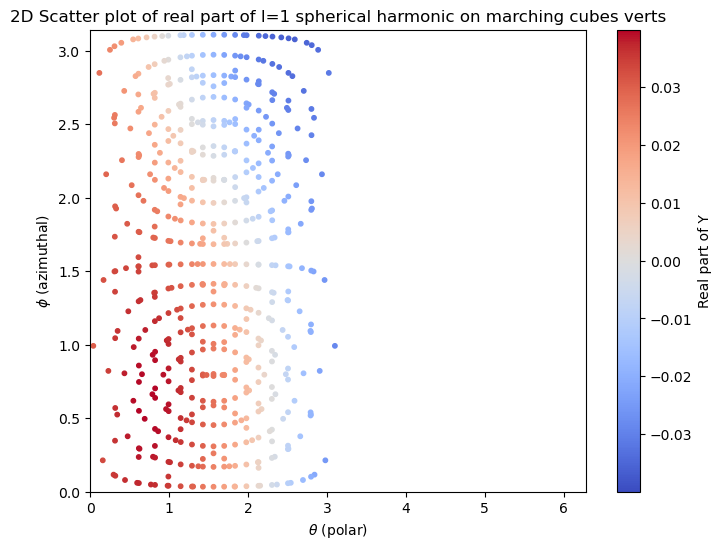

In [14]:
# l=1 mode
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# --- Your spherical harmonic coefficients ---
l = 1
zeta_lm = {m: coeffs[(l,m)] for m in range(-l, l+1)}

# --- Evaluate spherical harmonic sum at verts ---
Y_vals = np.zeros(len(verts), dtype=complex)
for m, coeff in zeta_lm.items():
    Y_vals += coeff * sph_harm(m, l, spherical_coords[2], spherical_coords[1])  # phi, theta

print(Y_vals.shape)
# --- Use real part or magnitude for coloring or displacement ---
color_values = Y_vals.real  # or np.abs(Y_vals)

# --- Normalize colors to [0,1] for plotting ---
colors_norm = (color_values - color_values.min()) / (color_values.ptp())

# Plot real part of Y vs (phi, theta)
plt.figure(figsize=(8,6))
sc = plt.scatter(spherical_coords[1], spherical_coords[2], c=Y_vals.real, cmap='coolwarm', s=10, marker='o')
plt.colorbar(sc, label='Real part of Y')
plt.xlabel(r'$\theta$ (polar)')
plt.ylabel(r'$\phi$ (azimuthal)')
plt.title('2D Scatter plot of real part of l=1 spherical harmonic on marching cubes verts')
plt.xlim(0, 2*np.pi)
plt.ylim(0, np.pi)
plt.show()



### Energy Equipartition

Each modes pair $Y_{l,\pm m}$ should correspond to one degree of freedom and possess energy $\frac{k_BT}{2}$.

The free energy is
\begin{aligned}
U&=\int\gamma dA=\gamma\left(\int r^{2}\left(\theta,\phi,t\right)\left[1+\frac{1}{2}\left|\nabla_{\Omega}r\left(\theta,\phi,t\right)\right|^{2}\right]\sin\theta d\theta d\phi-4\pi R_{0}^{2}\right)\\&\approx\gamma\int\left[r^{2}\left(\theta,\phi,t\right)+\frac{1}{2}R^{2}\left(t\right)\left|\nabla_{\Omega}\zeta\left(\theta,\phi,t\right)\right|^{2}+\mathcal{O}\left(\zeta^{3}\right)-R_{0}^{2}\right]\sin\theta d\theta d\phi \\
&\approx\frac{1}{2}\gamma\sum_{l\ge\left|m\right|,m\neq0}\left(l-1\right)\left(l+2\right)\left|\zeta_{lm}\left(t\right)\right|^{2}
\end{aligned}

$R_{0}$ is the radius at equilibrium state determined by volume conservation.

\begin{aligned}
U\left(t\right)	&=\frac{\gamma}{2}\sum_{l\ge\left|m\right|,m\neq0}\left(l-1\right)\left(l+2\right)\left|\zeta_{lm}\left(t\right)\right|^{2}\approx2\gamma\left(\left|\zeta_{2,0}\left(t\right)\right|^{2}+\left|\zeta_{2,-2}\left(t\right)\right|^{2}+\left|\zeta_{2,2}\left(t\right)\right|^{2}\right)
\end{aligned}

if **ellipsoid assumption** is correct, it should be equal to

$$U\left(t\right)=\underbrace{\frac{8\pi}{5}\gamma \left[\delta a\left(t\right)+\delta b\left(t\right)\right]^{2}}_{2\gamma\left|\zeta_{2,0}\left(t\right)\right|^{2}}+\underbrace{\frac{8\pi}{15}\gamma\left[\delta a\left(t\right)-\delta b\left(t\right)\right]^{2}}_{2\gamma\left(\left|\zeta_{2,-2}\left(t\right)\right|^{2}+\left|\zeta_{2,2}\left(t\right)\right|^{2}\right)}$$

$$\frac{8\pi}{5}\gamma\left\langle \left[\delta a\left(t\right)+\delta b\left(t\right)\right]^{2}\right\rangle \stackrel{?}{=}\frac{k_{B}T}{2}\tag{1}$$
$$2\gamma\left\langle \left|\zeta_{2,0}\left(t\right)\right|^{2}\right\rangle \stackrel{?}{=}\frac{k_{B}T}{2}\tag{2}$$
$$\frac{8\pi}{15}\gamma\left\langle \left[\delta a\left(t\right)-\delta b\left(t\right)\right]^{2}\right\rangle \stackrel{?}{=}\frac{k_{B}T}{2}\tag{3}$$
$$2\gamma\left\langle \left|\zeta_{2,-2}\left(t\right)\right|^{2}+\left|\zeta_{2,2}\left(t\right)\right|^{2}\right\rangle \stackrel{?}{=}\frac{k_{B}T}{2}\tag{4}$$

### PLot both fluctuating & equilibrium droplet

                fluctuating droplet frames range: frame1 ~ frame2 with interval: plot_int

yt : [INFO     ] 2025-08-14 23:35:21,610 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-08-14 23:35:21,611 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:35:21,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-14 23:35:21,612 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-14 23:35:21,680 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-08-14 23:35:21,680 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-08-14 23:35:21,683 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-08-14 23:35:21,683 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-08-14 23:35:21,686 Making a fixed resolution buffer of (('boxlib', 'rho_eq')) 800 by 800



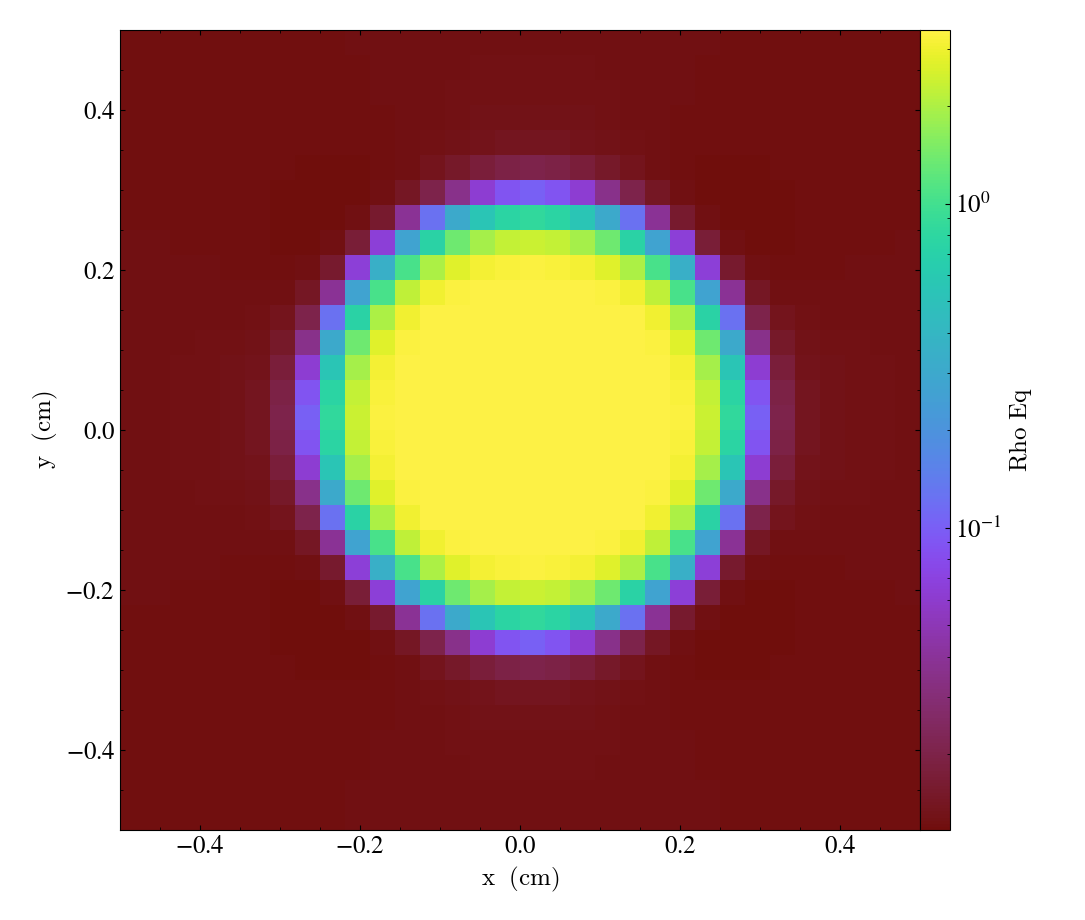

yt : [INFO     ] 2025-08-14 23:35:22,223 Parameters: current_time              = 2620000.0
yt : [INFO     ] 2025-08-14 23:35:22,223 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-14 23:35:22,224 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-14 23:35:22,225 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-14 23:35:22,286 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-08-14 23:35:22,287 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-08-14 23:35:22,290 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-08-14 23:35:22,290 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-08-14 23:35:22,292 Making a fixed resolution buffer of (('boxlib', 'rho')) 800 by 800



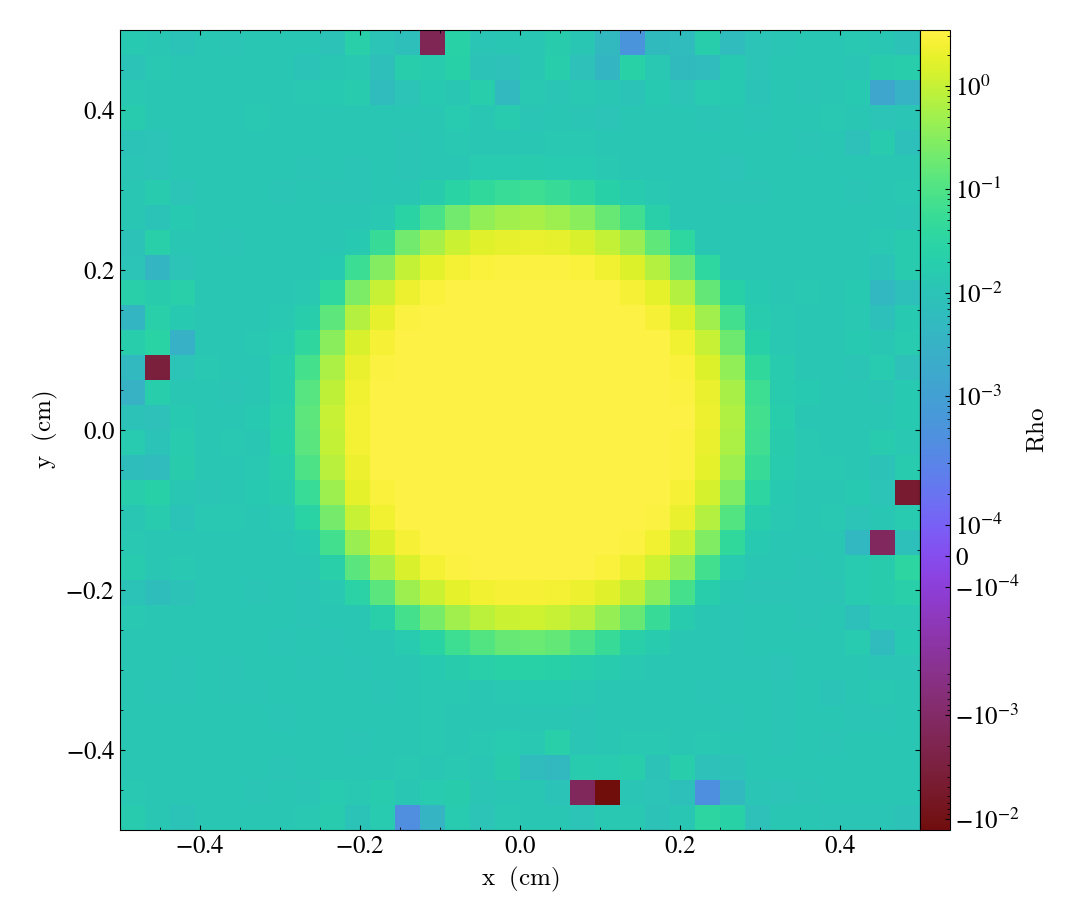

In [16]:
ds = yt.load(file_path_eq)  # Or use a pattern like "plt*"
sl = yt.SlicePlot(ds, "z", "rho_eq")  # Make a 2D slice plot of component "comp0"
sl.show()
#print(ds.domain_left_edge, ds.domain_right_edge, ds.domain_dimensions)

file_path_fluctuating = "./data_droplet_alpha0_{:.2f}_r{:.2f}_size{:d}-{:d}-{:d}/lbm_data_shshan_alpha0_".format(alpha0, r_init, nx, ny, nz) + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}_continue/".format(nx, ny, nz) + "plt" + f"{frame1:07d}"
ds = yt.load(file_path_fluctuating)  # Or use a pattern like "plt*"
sl = yt.SlicePlot(ds, "z", "rho")  # Make a 2D slice plot of component "comp0"
sl.show()
#print(ds.domain_left_edge, ds.domain_right_edge, ds.domain_dimensions)

In [17]:
N = rho_frames_tensor.shape[0]
print("Total frames for ensemble average analysis:", N)
rho_max_vals = np.max(rho_frames_tensor, axis=(1, 2, 3))
rho_min_vals = np.min(rho_frames_tensor, axis=(1, 2, 3))
zeta_1m1 = np.zeros(N, dtype=complex)
zeta_10 = np.zeros(N, dtype=complex)
zeta_11 = np.zeros(N, dtype=complex)
zeta_2m2 = np.zeros(N, dtype=complex)
zeta_2m1 = np.zeros(N, dtype=complex)
zeta_20 = np.zeros(N, dtype=complex)
zeta_21 = np.zeros(N, dtype=complex)
zeta_22 = np.zeros(N, dtype=complex)
for n in range(N):
    out_freq = max(1, N//10)
    if n % out_freq == 0 or n == N-1:
        print(f"Processing frame {n} ... ")
    coeffs, verts, faces, spherical_coords = \
        spherical_harmonics_coefficients(rho_frames_tensor, centers_of_mass, print_info=False, frame_select_idx=n, L_max=2)
    zeta_1m1[n] = coeffs[1, -1]
    zeta_10[n] = coeffs[1, 0]
    zeta_11[n] = coeffs[1, 1]
    zeta_2m2[n] = coeffs[2, -2]
    zeta_2m1[n] = coeffs[2, -1]
    zeta_20[n] = coeffs[2, 0]
    zeta_21[n] = coeffs[2, 1]
    zeta_22[n] = coeffs[2, 2]


Total frames for ensemble average analysis: 2301
Processing frame 0 ... 
Sum w_omega (solid angle summation):  12.603509897256759 theoretical:  12.566370614359172
Sum w_omega (solid angle summation):  12.60345127430267 theoretical:  12.566370614359172
Sum w_omega (solid angle summation):  12.60351768925739 theoretical:  12.566370614359172
Sum w_omega (solid angle summation):  12.603467656530075 theoretical:  12.566370614359172
Sum w_omega (solid angle summation):  12.603518042371403 theoretical:  12.566370614359172
Sum w_omega (solid angle summation):  12.603450279440342 theoretical:  12.566370614359172
Sum w_omega (solid angle summation):  12.603513544523857 theoretical:  12.566370614359172
Sum w_omega (solid angle summation):  12.60348085129078 theoretical:  12.566370614359172
Sum w_omega (solid angle summation):  12.603532568402724 theoretical:  12.566370614359172
Sum w_omega (solid angle summation):  12.603539143190542 theoretical:  12.566370614359172
Sum w_omega (solid angle summa

In [18]:
mean_square_zeta_1m1 = np.mean(zeta_1m1**2)
mean_square_zeta_10 = np.mean(zeta_10**2)
mean_square_zeta_11 = np.mean(zeta_11**2)
mean_square_zeta_2m2 = np.mean(zeta_2m2**2)
mean_square_zeta_2m1 = np.mean(zeta_2m1**2)
mean_square_zeta_20 = np.mean(zeta_20**2)
mean_square_zeta_21 = np.mean(zeta_21**2)
mean_square_zeta_22 = np.mean(zeta_22**2)

gamma_theory = 0.01216 # Theoretical value for gamma, see Surface_Tension.ipynb
print("energy equipartition LHS", 2*gamma_theory*mean_square_zeta_20)
print("energy equipartition RHS", temperature/2.0)


energy equipartition LHS (2.548764393547225e-07+0j)
energy equipartition RHS 5e-06


Total surface energy without truncation $F=\gamma\left(S_\text{fluctuating\_droplet} - S_0\right)$ in which $S_0$ is the radius of equilibrium state radius, same as above.

### Verification of fluctuating radius expansion relation

$$R^{2}\left(t\right)=R_{0}^{2}-\frac{1}{2\pi}\int\zeta^{2}\left(\theta,\phi,t\right)\sin\theta d\theta d\phi$$

\begin{aligned}
R^{2}\left(t\right)	&=R_{0}^{2}-\frac{1}{2\pi}\int\zeta^{2}\left(\theta,\phi,t\right)d\Omega \\
	&=R_{0}^{2}-\frac{1}{2\pi}\int\left|\sum_{l=1}\sum_{\left|m\right|\le l,m=-l}^{l}\zeta_{lm}\left(t\right)Y_{lm}\left(\theta,\phi\right)\right|^{2}d\Omega \\
	&=R_{0}^{2}-\frac{1}{2\pi}\int\left(\sum_{l=1}\sum_{\left|m\right|\le l,m=-l}^{l}\zeta_{lm}^{*}\left(t\right)Y_{lm}^{*}\left(\theta,\phi\right)\right)\left(\sum_{l=1}\sum_{\left|m\right|\le l,m=0}^{l}\zeta_{lm}\left(t\right)Y_{lm}\left(\theta,\phi\right)\right)d\Omega \\
	&=R_{0}^{2}-\frac{1}{2\pi}\sum_{l=1}\sum_{\left|m\right|\le l,m=-l}^{l}\sum_{l^{\prime}=1}\sum_{\left|m^{\prime}\right|\le l^{\prime},m^{\prime}=-l^{\prime}}^{l^{\prime}}\zeta_{lm}^{*}\left(t\right)\zeta_{l^{\prime}m^{\prime}}\left(t\right)\int Y_{lm}^{*}\left(\theta,\phi\right)Y_{l^{\prime}m^{\prime}}\left(\theta,\phi\right)d\Omega \\
	&=R_{0}^{2}-\frac{1}{2\pi}\sum_{l=1}\sum_{\left|m\right|\le l,m=-l}^{l}\left|\zeta_{lm}\left(t\right)\right|^{2}
\end{aligned}

From above we know,
\begin{aligned}
U\left(t\right)	\approx2\gamma\left(\left|\zeta_{2,0}\left(t\right)\right|^{2}+\left|\zeta_{2,-2}\left(t\right)\right|^{2}+\left|\zeta_{2,2}\left(t\right)\right|^{2}\right)
\end{aligned}

In [ ]:
file_path_eq = "./data_droplet_alpha0_{:.2f}_r{:.2f}_size{:d}-{:d}-{:d}/equilibrium_rho_alpha0_1.50_size32-32-32".format(alpha0, r_init, nx, ny, nz)
ts = yt.load(file_path_eq)
#print(ts.field_list)
profile_data = ts.covering_grid(level=0, left_edge=ts.domain_left_edge, dims=ts.domain_dimensions)
rho_field_eq = profile_data['boxlib', 'rho_eq']
rho_field_eq_max = rho_field_eq.max()
R0 = (np.sum(rho_field_eq)/(4./3.*np.pi*rho_field_eq_max))**(1./3.)  # Compute the radius of the droplet in equilibrium
S0 = 4.*np.pi*R0**2  # Compute the surface area of the droplet in equilibrium
print("Equilibrium droplet radius R0 =", R0, "and surface area S0 =", S0)

frame_select_idx = 0
rho_lo = rho_field_eq.min()
rho_hi = rho_field_eq.max()
rho_interface_level = 0.5 * (rho_lo + rho_hi)  # example
verts, faces, normals, values = measure.marching_cubes(rho_field_eq, level=rho_interface_level)
shifted_verts = verts - centers_of_mass[frame_select_idx]
v0 = shifted_verts[faces[:,0]] # of size (num_of_faces, 3), in which faces[:,0] is the index of the first vertex of each triangle
v1 = shifted_verts[faces[:,1]]
v2 = shifted_verts[faces[:,2]]
cross = np.cross(v1 - v0, v2 - v0) # surface area for each triangle
triangle_area = 0.5 * np.linalg.norm(cross, axis=1)  # Triangle areas, of size (num_of_faces, 1)
S_fluctuating = np.sum(triangle_area)
print("Instantaneous droplet surface area from marching cubes meshes S_fluctuating =", S_fluctuating)
Rt = np.mean(np.linalg.norm(shifted_verts, axis=1))
print("Instantaneous angular average radius by averaging vertices R(t)=", Rt)

r_angular_average = (coeffs[0,0] * sph_harm(0, 0, spherical_coords[2], spherical_coords[1]))[0]
print("Instantaneous angular average radius by harmonic expansion mode Y_00 =", r_angular_average)

RHS = 0
coeffs, verts, faces, spherical_coords = \
        spherical_harmonics_coefficients(rho_frames_tensor, centers_of_mass, False, 0, 3)
for l in range(1, 4):
    for m in range(-l, l+1):
        factor = 1./2.*np.pi
        # Y_mn complex scalar or ndarray for sph_harm
        RHS += factor * coeffs[(l,m)] * np.conj(coeffs[(l,m)])
        if l == np.abs(m):
            print(f"l={l}, m={m}, coeffs_lm={coeffs[(l,m)]}")
RHS = R0**2 - RHS
LHS = Rt**2
print("LHS (R(t)^2) =", LHS, "RHS =", RHS)

yt : [INFO     ] 2025-08-19 02:15:32,092 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-08-19 02:15:32,093 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-19 02:15:32,094 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-19 02:15:32,094 Parameters: domain_right_edge         = [1. 1. 1.]


Equilibrium droplet radius R0 = 7.655353005868813 dimensionless and surface area S0 = 736.4449825554804 dimensionless
Instantaneous droplet surface area from marching cubes meshes S_fluctuating = 684.546509673824
Instantaneous angular average radius by averaging vertices R(t)= 7.398711662638167
Instantaneous angular average radius by harmonic expansion mode Y_00 = (7.395498664231833+0j)
Sum w_omega (solid angle summation):  12.603509897256759 theoretical:  12.566370614359172
Test for constant function f = 1: coeff_00*Y00 =  [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j] theoretical:  1.0
l=1, m=-1, coeffs_lm=(0.0317682212025624+0.022836262482869824j)
l=1, m=1, coeffs_lm=(-0.0317682212025624+0.022836262482869824j)
l=2, m=-2, coeffs_lm=(0.005053793461820884-0.007747298196075223j)
l=2, m=2, coeffs_lm=(0.005053793461819554+0.0077472981960753865j)
l=3, m=-3, coeffs_lm=(0.006551248768798487+0.0006030697970723566j)
l=3, m=3, coeffs_lm=(-0.006551248768798487+0.0006030697970723566j)
LHS (R(t)^